11214369 - Nguyen Vu Anh Ngoc

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Problem 1
Re-implement TSNE.

In [2]:
import numpy as np

class MyTSNE:
    def __init__(self, n_components=2, perplexity=30.0, n_iter=1000, learning_rate=200.0, random_state=None):
        self.num_components = n_components
        self.perplexity = perplexity      
        self.max_iter = n_iter      
        self.learning_rate = learning_rate
        # Random state for reproducibility, used in initializing the embeddings
        self.random_state = np.random.RandomState(random_state) if random_state else np.random

    def _compute_squared_euclidean_distances(self, X):
        # Compute the negative squared Euclidean distances in the high-dimensional space.
        sum_X = np.sum(np.square(X), axis=1)
        distances = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
        return -distances

    def _apply_softmax(self, distances, diagonal_to_zero=True):
        # Apply softmax function to the distance matrix.
        e_x = np.exp(distances - np.max(distances, axis=1).reshape([-1, 1]))
        if diagonal_to_zero:
            np.fill_diagonal(e_x, 0.)  # Zero out diagonal to ignore self-distances
        e_x = e_x + 1e-8  # Add a small constant for numerical stability
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    def _compute_probabilities(self, distances, sigmas=None):
        # Compute joint probabilities from the distances in high-dimensional space.
        if sigmas is not None:
            # If sigma values are provided, use them to scale the distances
            two_sigma_squared = 2. * np.square(sigmas.reshape((-1, 1)))
            return self._apply_softmax(distances / two_sigma_squared)
        else:
            # Otherwise, use the distances as they are
            return self._apply_softmax(distances)

    def _compute_perplexity(self, prob_matrix):
        # Compute the perplexity of the probability distribution.
        entropy = -np.sum(prob_matrix * np.log2(prob_matrix), axis=1)
        return 2 ** entropy

    def _binary_search(self, eval_function, target, tolerance=1e-10, max_iterations=10000, lower_bound=1e-20, upper_bound=1000.):
        # Perform binary search to find the sigma that gives the target perplexity.
        for i in range(max_iterations):
            guess = (lower_bound + upper_bound) / 2.
            value = eval_function(guess)
            if value > target:
                upper_bound = guess
            else:
                lower_bound = guess
            if np.abs(value - target) <= tolerance:
                break
        return guess

    def _perplexity_for_sigma(self, distances, sigmas):
        # Compute perplexity for given sigma values.
        return self._compute_perplexity(self._compute_probabilities(distances, sigmas))

    def _find_optimal_sigmas(self, distances, target_perplexity):
        # Optimize sigma values for each data point to achieve the target perplexity.
        optimal_sigmas = []
        for i in range(distances.shape[0]):
            eval_fn = lambda sigma: self._perplexity_for_sigma(distances[i:i+1, :], np.array(sigma))
            sigma = self._binary_search(eval_fn, target_perplexity)
            optimal_sigmas.append(sigma)
        return np.array(optimal_sigmas)

    def _convert_conditional_to_joint_probabilities(self, P):
        # Convert conditional probabilities to joint probabilities.
        return (P + P.T) / (2. * P.shape[0])

    def _compute_low_dimensional_affinities(self, Z):
        # Compute joint probabilities in the low-dimensional space.
        distances = self._compute_squared_euclidean_distances(Z)
        exp_distances = np.exp(distances)
        np.fill_diagonal(exp_distances, 0.)  # Zero out self-distances
        return exp_distances / np.sum(exp_distances)

    def _compute_gradient(self, P, Q, Z):
        # Compute gradient of the Kullback-Leibler divergence for t-SNE.
        pq_difference = P - Q
        pq_expanded = np.expand_dims(pq_difference, 2)
        y_differences = np.expand_dims(Z, 1) - np.expand_dims(Z, 0)
        gradient = 4. * (pq_expanded * y_differences).sum(axis=1)
        return gradient

    def _compute_joint_probabilities_high_dim(self, X):
        # Compute joint probabilities in the high-dimensional space.
        distances = self._compute_squared_euclidean_distances(X)
        optimal_sigmas = self._find_optimal_sigmas(distances, self.perplexity)
        conditional_probabilities = self._compute_probabilities(distances, optimal_sigmas)
        return self._convert_conditional_to_joint_probabilities(conditional_probabilities)

    def fit_transform(self, X):
        # Fit the model to the data and transform it to a lower-dimensional space.
        P = self._compute_joint_probabilities_high_dim(X)
        Z = self.random_state.normal(0, 1e-4, [X.shape[0], self.num_components])
        for i in range(self.max_iter):
            Q = self._compute_low_dimensional_affinities(Z)
            gradients = self._compute_gradient(P, Q, Z)
            Z -= self.learning_rate * gradients

            # Calculate gradient norm for convergence checking.
            if np.linalg.norm(gradients) < 1e-7:
                break

            # Print progress and compute approximate KL divergence.
            if (i+1) % 100 == 0:
                Q = np.maximum(Q, 1e-12)
                kl_divergence = np.sum(P * np.log(P / Q))
                print(f'Iteration {i+1}, KL Divergence: {kl_divergence}')

        return Z

# Problem 2
Load MNIST dataset and visualize the image.

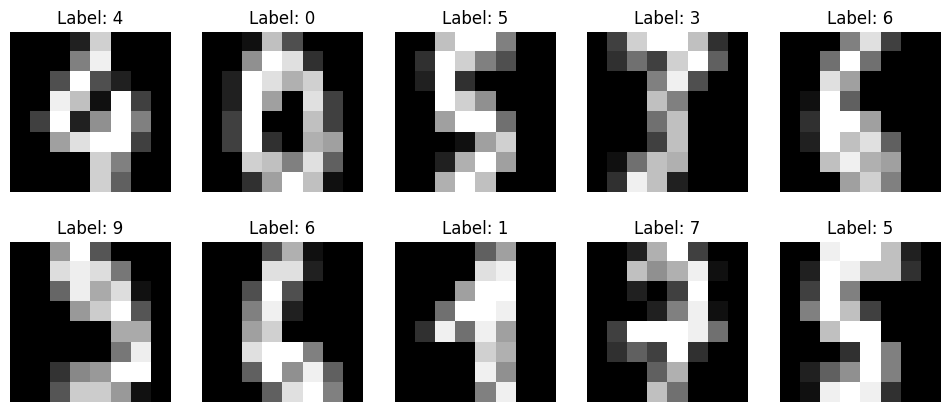

In [3]:
# Load MNIST dataset and visualize the image.
X_train, y_train = datasets.load_digits(return_X_y=True)

# Show 10 classes of the dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(100, 110):
    ax = axes[i // 5 - 20, i % 5]
    ax.imshow(X_train[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.show()

# Problem 3
Use YOUR IMPLEMENTATION ON PCA, as well as the design of T-SNE from above to reduce dimension into 2 and 3 dimensions, then visualize them. Give your comments on the result.

In [4]:
class MyPCA:
    def __init__(self, n_components: int):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.is_fitted = False
    
    def fit(self, X):
        # Standardize
        self.mean = np.mean(X, axis=0)
        X_std = X - self.mean

        # Calculate covariance matrix
        cov = np.cov(X_std.T)

        # Calculate eigens
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Sort eigenvectors descending by eigenvalues
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[:, idxs]

        # Store first n eigenvectors
        self.components = eigenvectors[:, :self.n_components]
        
        # Mark as fitted
        self.is_fitted = True

    def transform(self, X):
        # Validate
        if not self.is_fitted:
            raise Exception("Please call fit method before transform.")
        
        # Standardize
        X_std = X - self.mean

        # Project
        if self.n_components is None:
            raise Exception("Please call fit method before transform.")
        return np.dot(X_std, self.components) # type: ignore
        
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

In [5]:
# My PCA implementation
my_pca = MyPCA(n_components=2)
my_result_custom = my_pca.fit_transform(X_train)

# Sklearn PCA
sklearn_pca = PCA(n_components=2)
sklearn_result = sklearn_pca.fit_transform(X_train)

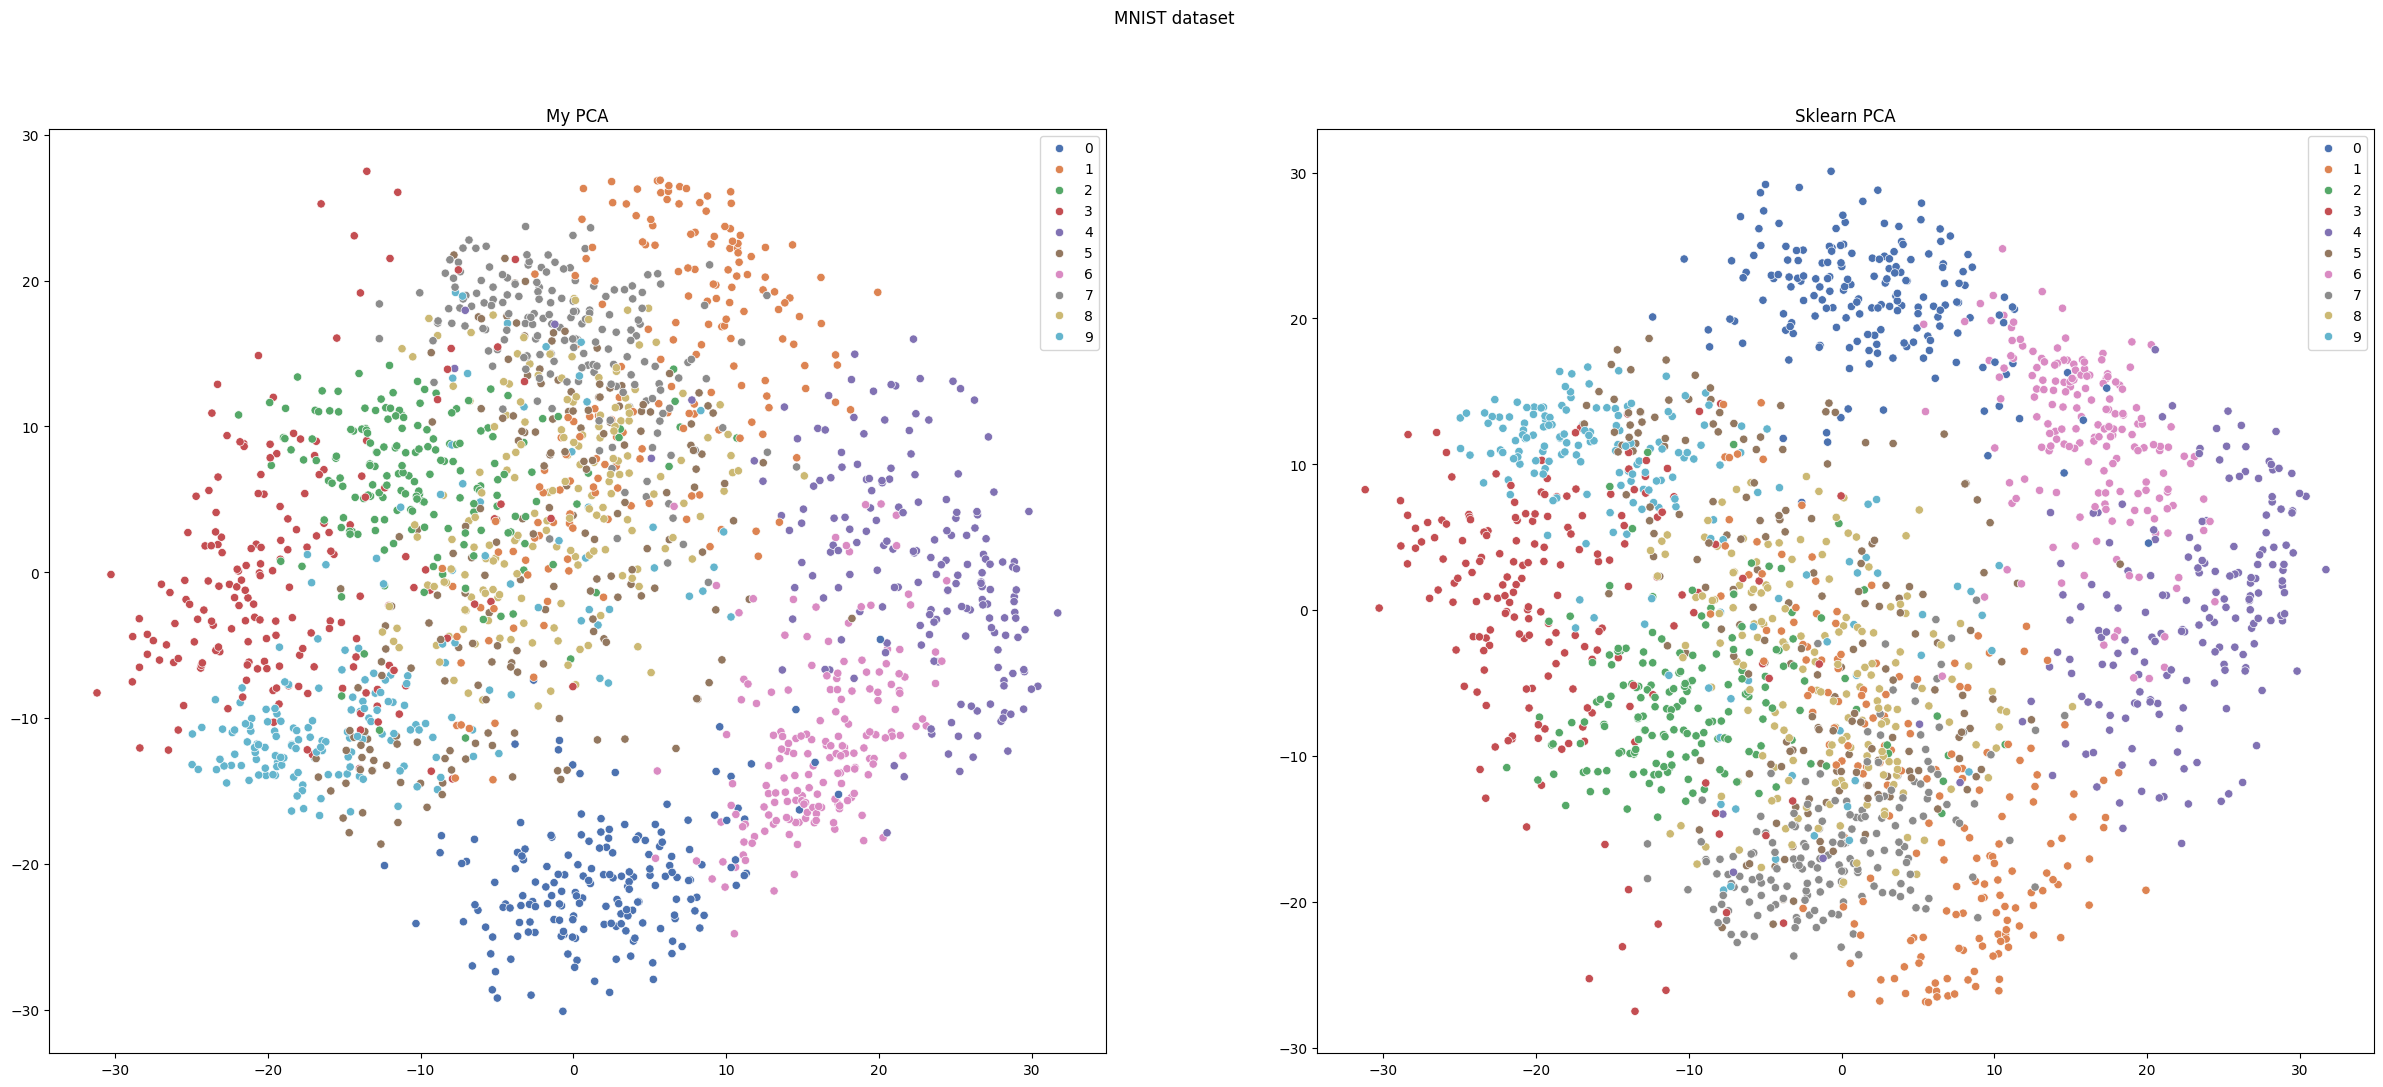

In [6]:
# Plotting and comparing results
fig, ax = plt.subplots(1, 2, figsize=(30, 12))
fig.suptitle('MNIST dataset')
ax[0].set_title('My PCA')
ax[1].set_title('Sklearn PCA')
sns.scatterplot(ax=ax[0], x=my_result_custom[:, 0], y=my_result_custom[:, 1], hue=y_train, palette='deep')
sns.scatterplot(ax=ax[1], x=sklearn_result[:, 0], y=sklearn_result[:, 1], hue=y_train, palette='deep')
plt.show()

In [7]:
# Reduce dimensionality with TSNE
tsne = MyTSNE(n_components=2, perplexity=25, learning_rate=400, n_iter=800)
my_result_custom = tsne.fit_transform(X_train)

Iteration 100, KL Divergence: 1.4104413723330944
Iteration 200, KL Divergence: 1.3476888057858003
Iteration 300, KL Divergence: 1.2852437817903144
Iteration 400, KL Divergence: 1.2510723629951768
Iteration 500, KL Divergence: 1.2512302727903812
Iteration 600, KL Divergence: 1.251308708719908
Iteration 700, KL Divergence: 1.2513205633234874
Iteration 800, KL Divergence: 1.25132263014608


In [8]:
# Reduce the dimensionality of the data using TSNE from sklearn
tsne = TSNE(n_components=2, verbose=0, n_iter=300, learning_rate=300)
sklearn_result = tsne.fit_transform(X_train)
print('KL Divergence of sklearn TSNE: ', tsne.kl_divergence_)

KL Divergence of sklearn TSNE:  0.9769103527069092


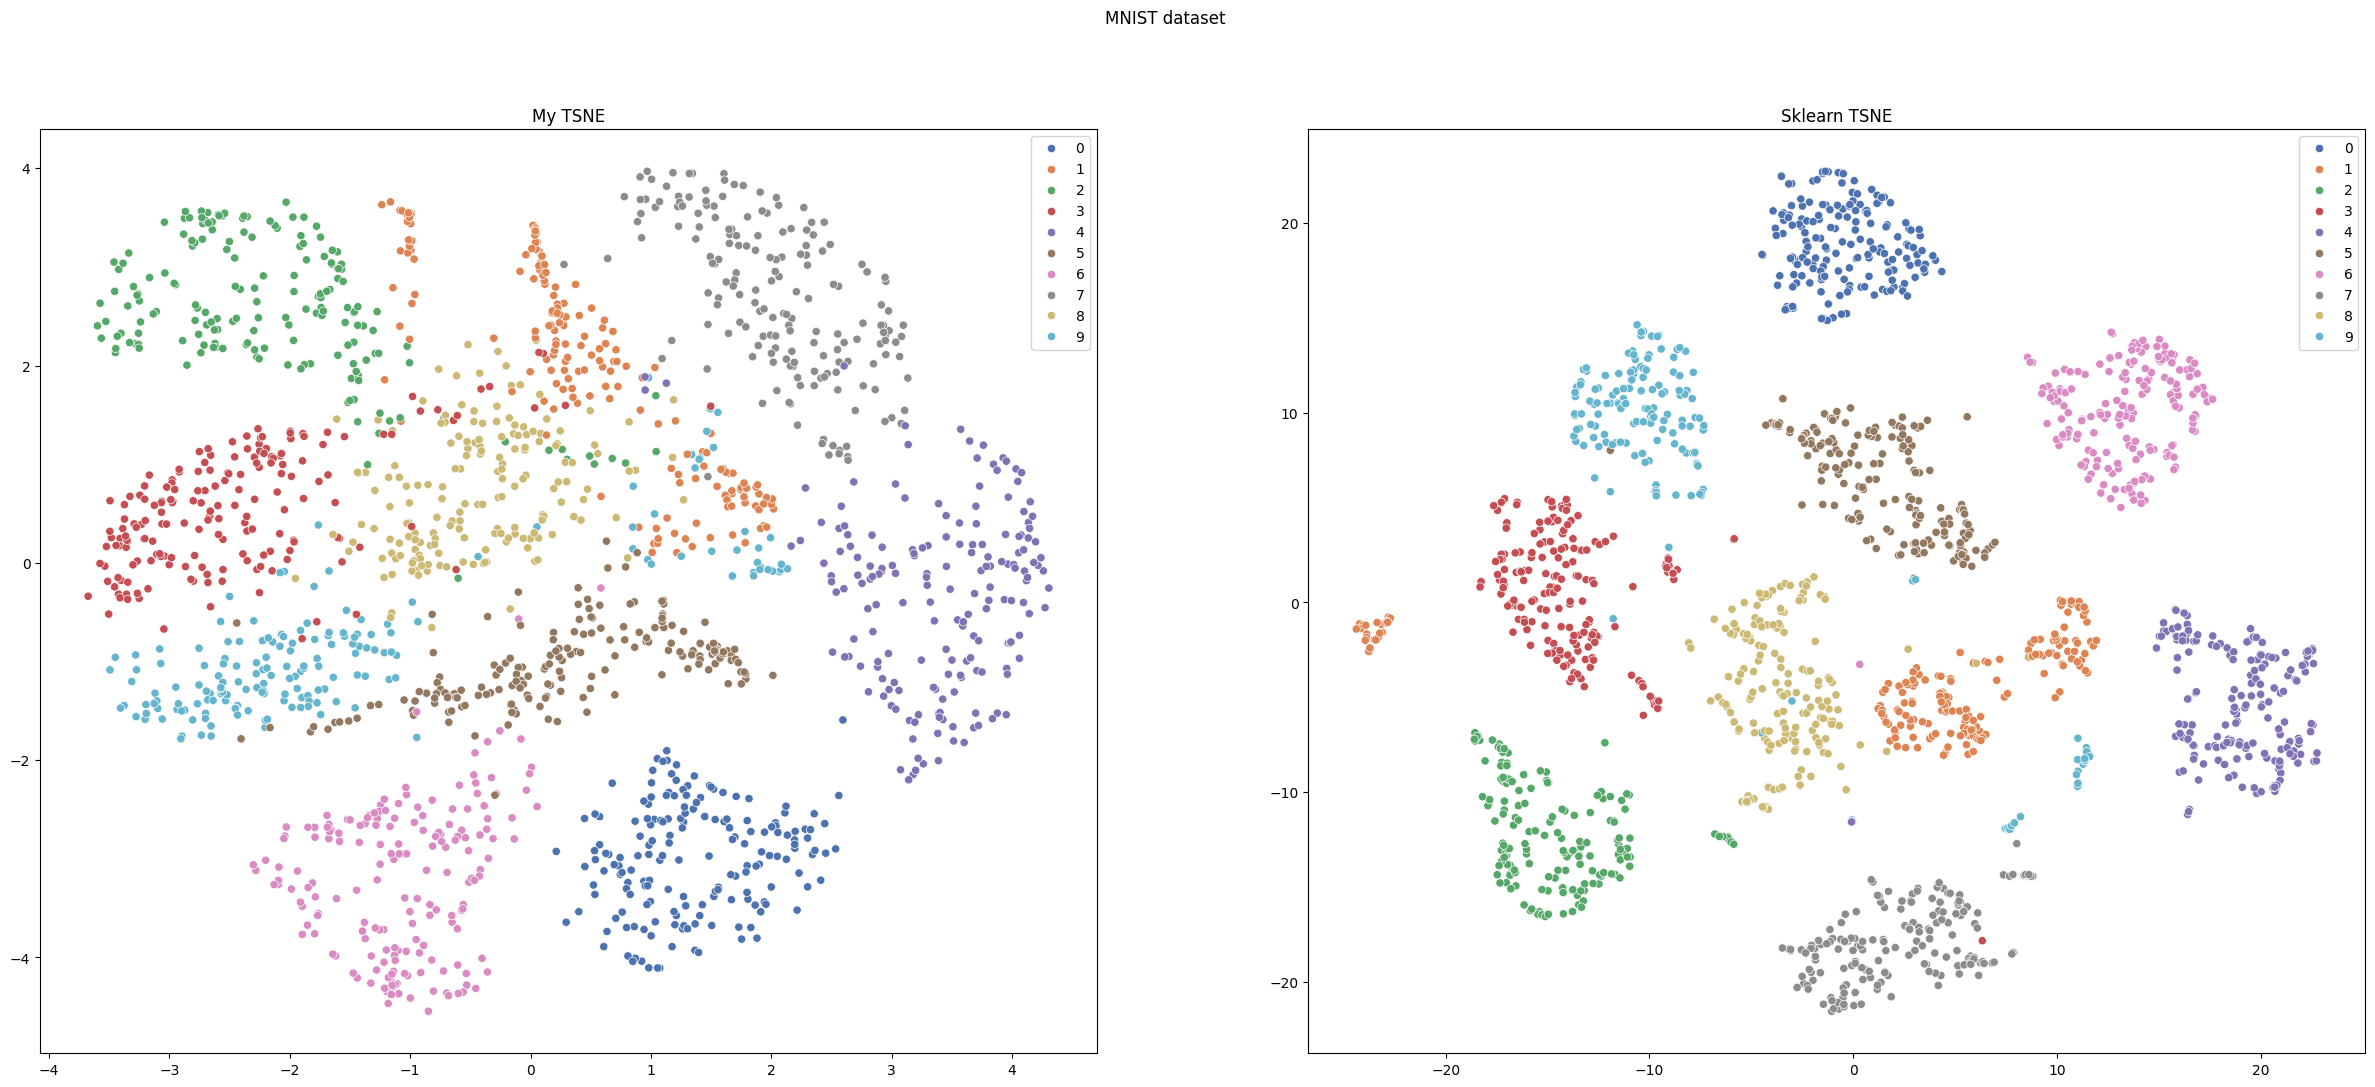

In [9]:
# Plotting and comparing results
fig, ax = plt.subplots(1, 2, figsize=(30, 12))
fig.suptitle('MNIST dataset')
ax[0].set_title('My TSNE')
ax[1].set_title('Sklearn TSNE')
sns.scatterplot(ax=ax[0], x=my_result_custom[:, 0], y=my_result_custom[:, 1], hue=y_train, palette='deep')
sns.scatterplot(ax=ax[1], x=sklearn_result[:, 0], y=sklearn_result[:, 1], hue=y_train, palette='deep')
plt.show()